In [2]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import math
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

In [3]:
model_rf = Model('ranf')

In [4]:
X,Y = model_rf.preprocessing.load_data('../../Frame_Analysis/Microsoft Ad Optimization-AI Data_Survey Aggregated Data 13062019.xlsx',labels=False,sheet_name="Sheet2")
X = X[X['Country']== 'US']
X= X.set_index(X['Video Name'])
Y = X[['Interest Trace']]

In [5]:
features = ['length_of_ad_15','ad_type_tv','Age','Gender','Emotion','Ethnicity',
            'Microsoft-Logo','Intel_Logo','Sub-Brands','Other-text',
            'Object 1-Laptop','object 2- Tablet','object 3-Mobile','object 4-PC']

In [6]:
class_dict ={}
le = LabelEncoder()

In [7]:
X_new = pd.DataFrame()
X_new['Video Name'] = X['Video Name']
X_new = X_new.set_index(X['Video Name'])

In [8]:
X_new['Ocr'] = X['Image Name'].apply(lambda x:float(x.split('_')[-1].replace('.jpg','')))

In [9]:
X_new['Length_of_ad'] = X['Length of the Ad']

In [10]:
def dur_division(x):
#     print(1,x)
    if x['Ocr']/x['Length_of_ad'] < 0.25:
        x['Ocr'] = 0
    elif x['Ocr']/x['Length_of_ad'] < 0.5:
        x['Ocr'] = 1
    elif x['Ocr']/x['Length_of_ad'] < 0.75:
        x['Ocr'] = 2
    else:
        x['Ocr'] = 3
    return x

In [11]:
X_new = X_new.apply(dur_division,axis=1)
X_new = X_new.drop('Length_of_ad',1)

In [12]:
arr = ["Laptop","Tablet","Mobile","PC"]
for i,c in enumerate(['Object 1-Laptop','object 2- Tablet','object 3-Mobile','object 4-PC']):
    X.loc[X[c]=="Yes",c] = arr[i]
    X.loc[X[c]=="yes",c] = arr[i]
    X.loc[X[c]=="No",c] = float('nan')
    X.loc[X[c]==" ",c] = float('nan')

In [13]:
X_new['length_of_ad_30'] = le.fit_transform(X['Length of the Ad'])
class_dict['length_of_ad_30'] = le.classes_
X_new['ad_type_tv'] = le.fit_transform(X['AD Type: TV/DIGITAL'])
class_dict['ad_type_tv'] = le.classes_

In [14]:
def separate(x,i):
    if x == 'No Face Found':
        return "nan"
    else:
        return np.array(x.replace('[','').replace(']','').replace("'",'').split(','))[i]

In [15]:
X['Age'] = X['Age-Gender'].apply(lambda x: separate(x,0))
X['Gender'] = X['Age-Gender'].apply(lambda x: separate(x,1))

In [16]:
ohe = OneHotEncoder()

In [17]:
data = ohe.fit_transform(np.reshape(X_new['Ocr'].values,(-1,1))).toarray()
class_ = ['frame_0_25','frame_25_50','frame_50_75','frame_75_100']
for c in ohe.categories_[0]:
    X_new[class_[int(c)]] = data[:,int(c)]
X_new = X_new.drop('Ocr',1)

In [18]:
for col in features[2:]:
    X[col] = X[col].apply(lambda x: "nan" if isinstance(x,type(float('nan'))) else x.lower())
    data = ohe.fit_transform(np.reshape(X[col].values,(-1,1))).toarray()  
    for i,unique_col in enumerate(ohe.categories_[0]):
        if unique_col != 'nan' and unique_col !='no face found' :
            X_new[unique_col] = data[:,i]
#     class_dict[col] = le.classes_

In [19]:
# new_features =[["happiness",' female'],["surprise"," male"],["neutral"," male"],["happiness","age: 0-5"],["disgust","age: 45-60"],["surprise","age: 0-5"],["neutral","age: 25-34"],["happiness","eastasian"],["surprise","eastasian"]]
# age_cols = ['age: 0-15', 'age: 0-5', 'age: 15-24','age: 25-34', 'age: 35-44', 'age: 45-60']
# ethinicity_cols = ['african', 'caucasian', 'eastasian','latino']
# age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
# new_features.extend(age_ethinicity_col)
# for f1,f2 in new_features:
#     X_new[f1+'_'+f2] = X[f1]+X[f2]
#     X_new[X_new[f1+'_'+f2] == 1] = 0
#     X_new[X_new[f1+'_'+f2] == 2] = 1
# X_new['Happiness_length_of_ad_impact'] = X_new['Happiness_dur'] * (1-X_new['length_of_ad_15'])

In [20]:
X_new.columns.values

array(['Video Name', 'length_of_ad_30', 'ad_type_tv', 'frame_0_25',
       'frame_25_50', 'frame_50_75', 'frame_75_100', 'age: 0-15',
       'age: 0-5', 'age: 15-24', 'age: 25-34', 'age: 35-44', 'age: 45-60',
       ' female', ' male', 'angry', 'disgust', 'fear', 'happiness',
       'neutral', 'sadness', 'surprise', 'african', 'caucasian',
       'eastasian', 'latino', 'microsoft', 'intel', 'asus t102',
       'dell pcs', 'dell xps 13', 'hp spectre x360',
       'hp spectre x360, windows', 'lenovo yoga 720', 'lenovo yoga 910',
       'macbook air', 'macbook pro', 'microsoft surface', 'suface laptop',
       'surface book', 'surface go', 'surface laptop', 'surface pen',
       'surface pro', 'surface pro 4',
       'surface pro 4, apple_macbookair13',
       'surface pro 4, hp spectre x360', 'surface pro 4, macbook air',
       'surface pro 4, macbook air13, macbook air',
       'surface pro 4, surface book', 'surface pro 4, windows 10',
       'surface pro 6', 'the new surface pro', 't

In [21]:
X_new

,Video Name,length_of_ad_30,ad_type_tv,frame_0_25,frame_25_50,frame_50_75,frame_75_100,age: 0-15,age: 0-5,age: 15-24,...,yoga,asus,dell,dell xps,hp,lenovo,laptop,tablet,mobile,pc
Video Name,,,,,,,,,,,,,,,,,,,,,
Yasmin Touch - ATL Win 10 15 TV US,Yasmin Touch - ATL Win 10 15 TV US,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yasmin Touch - ATL Win 10 15 TV US,Yasmin Touch - ATL Win 10 15 TV US,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yasmin Touch - ATL Win 10 15 TV US,Yasmin Touch - ATL Win 10 15 TV US,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yasmin Touch - ATL Win 10 15 TV US,Yasmin Touch - ATL Win 10 15 TV US,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yasmin Touch - ATL Win 10 15 TV US,Yasmin Touch - ATL Win 10 15 TV US,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yasmin Touch - ATL Win 10 15 TV US,Yasmin Touch - ATL Win 10 15 TV US,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yasmin Touch - ATL Win 10 15 TV US,Yasmin Touch - ATL Win 10 15 TV US,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yasmin Touch - ATL Win 10 15 TV US,Yasmin Touch - ATL Win 10 15 TV US,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yasmin Touch - ATL Win 10 15 TV US,Yasmin Touch - ATL Win 10 15 TV US,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_train,X_test,y_train,y_test = train_test_split(X_new,Y,test_size=0.3,random_state=123)

In [34]:
print("------------------------ RF Model Training ----------------------------\n")
trained_rf = model_rf.train(X_train,y_train,X_test,y_test,metrics='r2',set_params=True,params={'Interest Trace':{'bootstrap': False, 'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 2, 'n_estimators': 300}},plot_error=False)

------------------------ RF Model Training ----------------------------

Interest Trace


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
r2_score: 0.585368
For test set
r2_score: 0.621860




[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [40]:
model_xgb = Model('xgb')
print("------------------------ XGB Model Training ----------------------------\n")
trained_xgb = model_xgb.train(X_train,y_train,X_test,y_test,metrics='r2',set_params=True,params={'Interest Trace':{'colsample_bytree': 0.4, 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 1000,"objective":'reg:linear',"silent":False,"alpha":1,"learning_rate":0.01,"reg_lambda":1}},plot_error=False)

------------------------ XGB Model Training ----------------------------

Interest Trace


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished


For training set
r2_score: 0.592943
For test set
r2_score: 0.627158




Interest Trace
Feature ranking:
1. frame_0_25 (0.491100)
2. length_of_ad_30 (0.114169)
3. frame_50_75 (0.109685)
4. frame_75_100 (0.044076)
5. frame_25_50 (0.036863)
6. laptop (0.029246)
7. microsoft (0.022117)
8. tablet (0.016401)
9. neutral (0.012259)
10. ad_type_tv (0.010701)
11. age: 25-34 (0.008025)
12. age: 15-24 (0.007296)
13. caucasian (0.006954)
14. happiness (0.006889)
15.  female (0.006203)
16.  male (0.006200)
17. african (0.006034)
18. windows 10 (0.005021)
19. eastasian (0.004751)
20. dell xps (0.004657)
21. age: 45-60 (0.004638)
22. surface go (0.004570)
23. windows 10 pcs (0.004410)
24. hp (0.004277)
25. age: 35-44 (0.003936)
26. surface pro 6 (0.003506)
27. surprise (0.003227)
28. age: 0-5 (0.002841)
29. sadness (0.002461)
30. hp spectre x360, windows (0.002435)
31. surface laptop (0.002352)
32. surface book (0.002346)
33. surface pro 4 (0.002339)
34. latino (0.001709)
35. surface pro 4, apple_macbookair13 (0.000794)
36. the new surface pro (0.000640)
37. surface pro 4

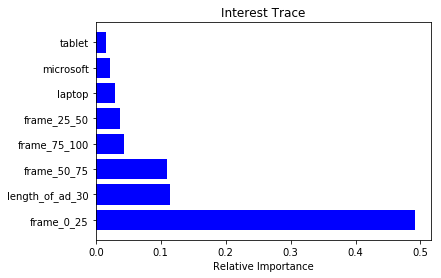

In [36]:
model_rf.plot_feature_importance(trained_rf,10,y_test.columns,X_test.columns[1:])

length_of_ad_30


IndexError: index 1 is out of bounds for axis 0 with size 1

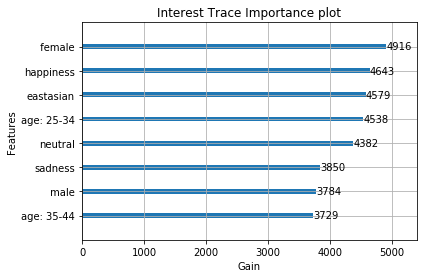

In [41]:
model_xgb.plot_feature_importance(trained_xgb,10,y_test.columns,X_test.columns[1:])

In [23]:
from sklearn.model_selection import GridSearchCV
parameters_tree={"colsample_bytree":[0.4,0.6],"max_depth":[6,8,13,15,20,50,100],"min_samples_leaf":[2,4],"n_estimators":[500,1000,2000,5000]}
grd = GridSearchCV(model_xgb.model,param_grid=parameters_tree,cv=3,return_train_score=True,verbose=1,n_jobs=-1,scoring='r2')

In [24]:
# grd.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])

In [42]:
for i in range(30):
    print("True Value: ",round(y_test.values[i:i+1,0][0],2),"Predicted Value:",round(model_rf.predict(X_test.iloc[i:i+1]).values[0,0],2),)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

True Value:  16.4 Predicted Value: 18.64
True Value:  17.31 Predicted Value: 16.12
True Value:  10.04 Predicted Value: 13.95
True Value:  23.14 Predicted Value: 19.11
True Value:  24.29 Predicted Value: 22.32
True Value:  1.01 Predicted Value: 3.3
True Value:  18.27 Predicted Value: 19.07
True Value:  5.78 Predicted Value: 10.15
True Value:  20.11 Predicted Value: 10.19
True Value:  25.28 Predicted Value: 22.3
True Value:  11.85 Predicted Value: 8.74
True Value:  0.0 Predicted Value: 17.36
True Value:  2.51 Predicted Value: 6.44
True Value:  22.4 Predicted Value: 22.28


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True Value:  21.92 Predicted Value: 22.94
True Value:  21.91 Predicted Value: 20.47
True Value:  8.5 Predicted Value: 3.3
True Value:  19.06 Predicted Value: 17.36
True Value:  20.47 Predicted Value: 22.3
True Value:  30.61 Predicted Value: 17.36
True Value:  23.13 Predicted Value: 20.33
True Value:  28.36 Predicted Value: 17.36
True Value:  19.49 Predicted Value: 20.33
True Value:  8.66 Predicted Value: 13.5
True Value:  15.15 Predicted Value: 16.37
True Value:  19.0 Predicted Value: 18.64
True Value:  20.92 Predicted Value: 18.89
True Value:  8.72 Predicted Value: 7.6
True Value:  22.12 Predicted Value: 22.49
True Value:  0.0 Predicted Value: 3.3


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [43]:
from sklearn.linear_model import LinearRegression,LassoCV,BayesianRidge
from sklearn.metrics import r2_score

In [44]:
lr = LinearRegression(normalize=False)
lasso_cv = LassoCV(verbose=True)
br = BayesianRidge(n_iter=1000)

In [45]:
lr = lr.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])
lasso_cv = lasso_cv.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])
br = br.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [46]:
print("Linear Regression Model",r2_score(y_test['Interest Trace'],lr.predict(X_test.drop('Video Name',1))))
print("Lasso Model",r2_score(y_test['Interest Trace'],lasso_cv.predict(X_test.drop('Video Name',1))))
print("Bayesian Ridge",r2_score(y_test['Interest Trace'],br.predict(X_test.drop('Video Name',1))))
print("XGB Model",r2_score(y_test['Interest Trace'],model_xgb.predict(X_test.drop('Video Name',1))))
print("RF Model",r2_score(y_test['Interest Trace'],model_rf.predict(X_test.drop('Video Name',1))))

Linear Regression Model 0.5390025537030657
Lasso Model 0.539041670409858
Bayesian Ridge 0.5390623447859804
XGB Model 0.6271575355166332
RF Model 0.6218604738037852


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [47]:
shap.initjs()
explainer_rf= shap.TreeExplainer(trained_rf[0])
shap_values_rf= explainer_rf.shap_values(X_train.drop('Video Name',1))

In [49]:
explainer_xgb = shap.TreeExplainer(trained_xgb[0])
shap_values_xgb= explainer_xgb.shap_values(X_train.drop('Video Name',1))

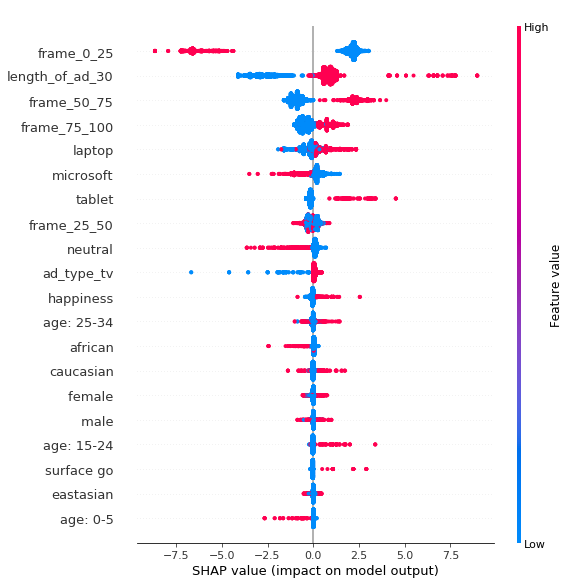

In [48]:
shap.summary_plot(shap_values_rf,X_train.drop('Video Name',1))

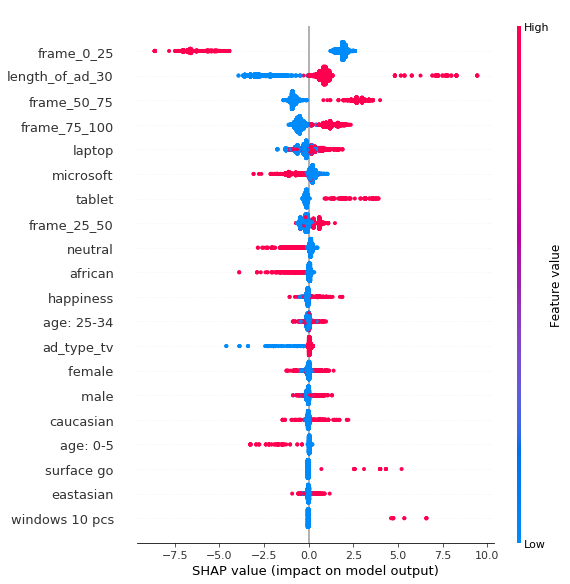

In [50]:
shap.summary_plot(shap_values_xgb,X_train.drop('Video Name',1))

In [61]:
indices = np.argsort(lr.coef_)

In [57]:
X_train.drop('Video Name',1).columns[indices]

Index(['neutral', 'disgust', 'angry', 'happiness', 'sadness', 'fear',
       'surprise', ' male', ' female', 'asus t102', 'dell xps 13', 'lenovo',
       'surface pro 4, apple_macbookair13', 'windows 10, windows',
       'suface laptop', 'intel', 'hp', 'surface pro 4, surface book',
       'surface pro 4, macbook air13, macbook air', 'microsoft',
       'hp spectre x360, windows', 'surface pen', 'the surface laptop',
       'surface laptop', 'laptop', 'windows 10', 'surface pro', 'macbook air',
       'macbook pro', 'hp spectre x360', 'surface pro 4', 'windows',
       'ad_type_tv', 'yoga', 'tablet', 'pc', 'surface pro 4, hp spectre x360',
       'surface book', 'surface pro 4, macbook air', 'length_of_ad_30',
       'windows 10 pc', 'microsoft surface', 'mobile', 'the new surface pro',
       'dell pcs', 'lenovo yoga 720', 'surface pro 4, windows 10',
       'surface go', 'windows 10, hp_spectre', 'windows 10 pcs',
       'surface pro 6', 'dell xps', 'lenovo yoga 910', 'dell', 'asus',

# NN

In [62]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import backend as K
from keras.regularizers import l2

Using TensorFlow backend.


In [69]:
def model_nn():
    model = Sequential()
    model.add(Dense(512,input_shape=(69,),activation='relu',kernel_initializer='normal'))
    model.add(Dense(256,activation='relu',kernel_initializer='normal'))
    model.add(Dense(256,activation='relu',kernel_initializer='normal'))
    
#     model.add(Dropout(0.4))
    model.add(Dense(128,activation='relu',kernel_initializer='normal'))
    model.add(Dense(128,activation='relu',kernel_initializer='normal'))
#     model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,activation='linear',kernel_initializer='normal'))
    
    return model

In [70]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [71]:
model = model_nn()
model.compile(optimizer='adam',loss="mean_squared_error",metrics=[r2_keras])

In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               35840     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total para

In [73]:
X_train_nn,X_test_nn,y_train_nn,y_test_nn = train_test_split(X_new,Y,test_size=0.3,random_state=123)

In [74]:
history = model.fit(X_train_nn.drop('Video Name',1).values,y_train_nn.values,epochs=100,verbose=1,validation_data=(X_test_nn.drop('Video Name',1).values,y_test_nn.values))

Instructions for updating:
Use tf.cast instead.
Train on 3731 samples, validate on 1600 samples
Epoch 1/100
3731/3731 [==============================] - 2s 431us/step - loss: 80.4503 - r2_keras: -0.5019 - val_loss: 29.1251 - val_r2_keras: 0.4671
Epoch 2/100
3731/3731 [==============================] - 0s 126us/step - loss: 26.8814 - r2_keras: 0.5111 - val_loss: 25.1448 - val_r2_keras: 0.5437
Epoch 3/100
3731/3731 [==============================] - 0s 126us/step - loss: 26.0544 - r2_keras: 0.5266 - val_loss: 40.7592 - val_r2_keras: 0.2342
Epoch 4/100
3731/3731 [==============================] - 0s 131us/step - loss: 25.3917 - r2_keras: 0.5289 - val_loss: 23.3417 - val_r2_keras: 0.5739
Epoch 5/100
3731/3731 [==============================] - 0s 127us/step - loss: 25.0907 - r2_keras: 0.5298 - val_loss: 23.3986 - val_r2_keras: 0.5711
Epoch 6/100
3731/3731 [==============================] - 1s 135us/step - loss: 24.0933 - r2_keras: 0.5574 - val_loss: 23.3791 - val_r2_keras: 0.5722
Epoch 7/1

3731/3731 [==============================] - 0s 125us/step - loss: 21.7334 - r2_keras: 0.6007 - val_loss: 21.7997 - val_r2_keras: 0.6007
Epoch 54/100
3731/3731 [==============================] - 0s 122us/step - loss: 21.8852 - r2_keras: 0.5966 - val_loss: 21.4703 - val_r2_keras: 0.6100
Epoch 55/100
3731/3731 [==============================] - 0s 123us/step - loss: 22.1475 - r2_keras: 0.5891 - val_loss: 21.9305 - val_r2_keras: 0.5997
Epoch 56/100
3731/3731 [==============================] - 0s 122us/step - loss: 21.3988 - r2_keras: 0.6017 - val_loss: 22.5062 - val_r2_keras: 0.5870
Epoch 57/100
3731/3731 [==============================] - 0s 122us/step - loss: 20.9993 - r2_keras: 0.6091 - val_loss: 21.4937 - val_r2_keras: 0.6077
Epoch 58/100
3731/3731 [==============================] - 0s 122us/step - loss: 21.1243 - r2_keras: 0.6100 - val_loss: 21.8041 - val_r2_keras: 0.6008
Epoch 59/100
3731/3731 [==============================] - 0s 123us/step - loss: 21.4469 - r2_keras: 0.6009 - val_

In [159]:
for i,val in enumerate(model.predict(X_test.drop('Video Name',1).values)):
#     print(round(y_test.values[i][0],2),round(val[0],2))
    pass

In [75]:
model.evaluate(X_test.drop('Video Name',1).values,y_test.values)

1600/1600 [==============================] - 0s 33us/step


[21.773721084594726, 0.6038555312156677]

In [77]:
import matplotlib.pyplot as plt

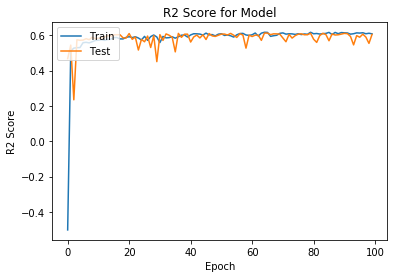

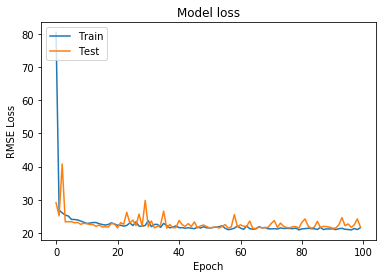

In [78]:
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('R2 Score for Model')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('RMSE Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()